In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np 
import tensorflow as tf
import time
from tensorflow.python.ops import init_ops
from tensorflow.keras import initializers
from tensorflow.python.training.moving_averages import assign_moving_average

#set up the neural network
def neural_net(x,neurons,is_training, name, mv_decay=0.9,dtype=tf.float32):

    #normalise the output using mean and sd of current input. 
    #more info @1502.03167
    
    def _batch_normalization(_x):
        #initialise offsets
        beta = tf.compat.v1.get_variable("beta",[_x.get_shape()[-1]],dtype,init_ops.zeros_initializer())
        
        #initialise scale
        gamma = tf.compat.v1.get_variable("gamma",[_x.get_shape()[-1]],dtype,init_ops.ones_initializer())
        
        mv_mean = tf.compat.v1.get_variable("mv_mean",[_x.get_shape()[-1]],dtype,init_ops.zeros_initializer(),trainable=False)
        
        mv_variance = tf.compat.v1.get_variable("mv_variance",[_x.get_shape()[-1]],dtype,init_ops.ones_initializer(),trainable=False)
        
        #calculate mean and variance from the current output
        mean,variance = tf.nn.moments(_x,[0],name="moments")
        
        tf.compat.v1.add_to_collection(tf.compat.v1.GraphKeys.UPDATE_OPS,assign_moving_average(mv_mean,mean,mv_decay,True))
        
        tf.compat.v1.add_to_collection(tf.compat.v1.GraphKeys.UPDATE_OPS,assign_moving_average(mv_variance,variance,mv_decay,False))

        mean,variance = tf.cond(is_training, 
                                lambda: (mean,variance),
                                lambda: (mv_mean,mv_variance))
        return tf.nn.batch_normalization(_x,mean,variance,beta,gamma,1e-6)

    #layers of the neural networks and initialise weights
    def _layer(_x,out_size,activation_fn):
        w = tf.compat.v1.get_variable("weights",[_x.get_shape().as_list()[-1],out_size],
                            dtype,
                            #aka xavier initialiser - keeps the scale of gradients roughly the same
                            initializers.glorot_normal())
        return activation_fn(_batch_normalization(tf.matmul(_x,w)))

    with tf.compat.v1.variable_scope(name,reuse = tf.compat.v1.AUTO_REUSE):
        x = _batch_normalization(x)
        for i in range(len(neurons)):
            with tf.compat.v1.variable_scope("layer_%i_" % (i+1)):
                #taking hyperbolic tan as non-linear activation function
                x = _layer(x,neurons[i],
                           tf.compat.v1.nn.tanh if i<len(neurons)-1 else tf.identity)
    return x

def kolmogorov_train_and_test(xi,x_sde,phi,u_reference,neurons,
                              lf_boundaries,lr_values,train_steps,
                              mc_rounds,mc_freq,file_name,
                              dtype=tf.float32):
  
    def _approximate_errors():
        lr,gs = sess.run([learning_rate,global_step])
        l1_err,l2_err,li_err = 0. , 0. , 0. 
        rel_l1_err,rel_l2_err,rel_li_err = 0.,0.,0.
        for _ in range(mc_rounds):
            l1,l2,li,rl1,rl2,rli \
              =sess.run([err_l_1,err_l_2,err_l_inf,
                         rel_err_l_1,rel_err_l_2,rel_err_l_inf],
                        feed_dict = {is_training: False})
            
            #cummulate errors
            l1_err,l2_err,li_err = (l1_err + l1, l2_err+l2,np.maximum(li_err,li))
            rel_l1_err,rel_l2_err,rel_li_err \
              = (rel_l1_err + rl1,rel_l2_err+rl2,np.maximum(rel_li_err,rli))
            l1_err,l2_err = l1_err / mc_rounds, np.sqrt(l2_err/mc_rounds)
            rel_l1_err, rel_l2_err \
              = rel_l1_err / mc_rounds, np.sqrt(rel_l2_err/mc_rounds)
            t_mc = time.time()
            file_out.write("%i, %f,%f,%f,%f,%f,%f,%f,%f,%f\n" % (gs,l1_err,l2_err,li_err,rel_l1_err,rel_l2_err,rel_li_err,lr,t1_train-t0_train,t_mc-t1_train))
            file_out.flush()

    t0_train = time.time()
    is_training = tf.compat.v1.placeholder(tf.bool,[])

    with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(),reuse=tf.compat.v1.AUTO_REUSE): 
        
        #run through the trained neural network
        u_approx = neural_net(xi,neurons,is_training,"u_approx",dtype = dtype)
        
        #compare with calculated value
        loss = tf.reduce_mean(tf.compat.v1.squared_difference(u_approx,phi(x_sde)))

        #compare nn approx value with mc values and calculate all errs
        err = tf.compat.v1.abs(u_approx - u_reference)
        err_l_1 = tf.compat.v1.reduce_mean(err)
        err_l_2 = tf.compat.v1.reduce_mean(err ** 2)
        err_l_inf = tf.compat.v1.reduce_max(err)
        
        #relative errors 
        rel_err = err/ tf.compat.v1.maximum(u_reference,1e-8)
        rel_err_l_1 = tf.compat.v1.reduce_mean(rel_err)
        rel_err_l_2 = tf.compat.v1.reduce_mean(rel_err ** 2)
        rel_err_l_inf = tf.compat.v1.reduce_max(rel_err)

        #
        global_step = tf.compat.v1.get_variable("global_step",[], tf.int32,
                                      tf.compat.v1.constant_initializer(),
                                      trainable = False)
        
        #
        learning_rate = tf.compat.v1.train.piecewise_constant(global_step,
                                                    lr_boundaries,
                                                    lr_values)
        
        
        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
        update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS,"u_appox")
        

        with tf.compat.v1.control_dependencies(update_ops):
            #minimise the loss take the gradient
            train_op = optimizer.minimize(loss, global_step)

        file_out = open(file_name,"w")
        file_out.write("step,l1_err,l2_err,li_err,l1_rel,l2_rel,li_rel,learning_rate,time_train,time_mc\n")

        #record errors at each step 
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())

            for step in range(train_steps):
                if step % mc_freq == 0:
                    t1_train = time.time()
                    _approximate_errors()
                    t0_train = time.time()
                
                sess.run(train_op,feed_dict = {is_training: True})

            t1_train = time.time()
            _approximate_errors()
        
        file_out.close()
        #file_out.save(file_name)
        #files.download(file_name)
    return file_out



In [3]:

#geometric BM 
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
tf.compat.v1.get_variable_scope().reuse_variables()

dtype = "float32"
T,N,d = 1.,1,10
r,c,K = 0.05,0.1,100.
mu = -0.05
sigma = tf.constant(0.1 + 0.5 * np.linspace(start=1./d,stop = 1.,num = d,endpoint = True,dtype = dtype))
batch_size = 500
neurons = [d+10,d+10,1]
train_steps = 30000
mc_rounds, mc_freq = 1,250
mc_samples_ref,mc_rounds_ref = 1000,1000
lr_boundaries = [10000,20000]
lr_values = [0.001,0.0001,0.00001]

#random starting points
xi = tf.random.uniform((batch_size,d),minval=90.,maxval=110.,dtype=dtype)

#u(0,x)
def phi(x,axis=1):
    return np.exp(-r*T) * tf.maximum(tf.reduce_max(x,axis=axis,keepdims=True)-K,0.)

def mc_body(idx,p):
    #actual stochastic diff equation for MC method
    #exact solution of a black scholes with gbm. 
    _x = xi * tf.exp((mu-0.5*sigma**2)*T + sigma *tf.random.normal((mc_samples_ref,batch_size,d),stddev=np.sqrt(T/N),dtype=dtype))
    return idx + 1, p+tf.reduce_mean(phi(_x,2),axis=0)

#the actual equation for solving
#used in training
x_sde = xi * tf.exp((r-c-0.5*sigma**2)*T +sigma*tf.random.normal((batch_size,d),stddev=np.sqrt(T/N),dtype=dtype))

#while index less than mc rounds ref, calculate mc value, else 0. 
_,u = tf.compat.v1.while_loop(lambda idx,p: idx<mc_rounds_ref, mc_body,(tf.constant(0),tf.zeros((batch_size,1),dtype)))

#find the comparison mc values
u_reference = u / tf.cast(mc_rounds_ref,dtype)

file_output = kolmogorov_train_and_test(xi,x_sde,phi,u_reference,neurons,lr_boundaries,lr_values,train_steps,mc_rounds,mc_freq,"GBM_test.csv",dtype)



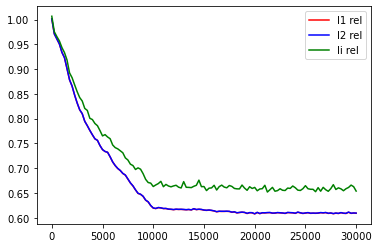

In [5]:
data = pd.read_csv("GBM_test.csv")
df = pd.DataFrame(data)
df.set_index("step",inplace =True)

plt.plot(df.index,df.l1_rel,color="red",label ="l1 rel")

plt.plot(df.index,df.l2_rel,color="blue",label ="l2 rel")

plt.plot(df.index,df.li_rel,color="green",label ="li rel")

plt.legend()

plt.show()

In [6]:
df.head(29)

,l1_err,l2_err,li_err,l1_rel,l2_rel,li_rel,learning_rate,time_train,time_mc
step,,,,,,,,,
0,66.651733,66.725263,76.422554,1.001230,1.001233,1.006573,0.001,1.835946,97.182954
250,64.582672,64.673074,73.031364,0.970878,0.970879,0.975259,0.001,1.334665,96.986524
500,63.897743,63.979098,72.070335,0.960752,0.960754,0.965445,0.001,0.801552,96.705263
750,63.308434,63.392125,71.464912,0.950624,0.950628,0.956686,0.001,0.875646,96.581293
1000,62.037601,62.123104,71.244408,0.933690,0.933696,0.943261,0.001,0.811380,96.458339
1250,61.249344,61.340435,69.523674,0.923000,0.923017,0.933270,0.001,0.775654,96.758604
1500,59.795147,59.884724,68.393295,0.900872,0.900906,0.918368,0.001,0.812913,96.619061
1750,58.479347,58.576406,66.897987,0.878306,0.878329,0.892310,0.001,0.789784,97.578598
2000,57.297070,57.385226,66.545082,0.865608,0.865636,0.882574,0.001,0.755219,99.824707
